## Import Module

In [91]:
import tensorflow as tf
import spacy
import pandas as pd,numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay,confusion_matrix
import keras
from keras.models import Sequential
from keras import layers
import matplotlib.pyplot as plt

In [ ]:
!python -m spacy download en_core_web_lg

In [7]:
nlp = spacy.load('en_core_web_lg')

## Load dataset

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/NLP-Tutorial-8---Sentiment-Classification-using-SpaCy-for-IMDB-and-Amazon-Review-Dataset/master/datasets/imdb_labelled.txt', sep = '\t', header = None)
df = df.rename(columns = {0:'text',1:"seniment"})
df.head(2)

,text,seniment
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0


In [32]:
df.isna().sum()

text        0
seniment    0
dtype: int64

## Text pre-processing

In [33]:
stop_word = nlp.Defaults.stop_words
def clean_text(text):
    text = text.lower() #
    text = re.sub(r'http\S+','',text) # remove url
    text = re.sub(r'[^\w ]+', " ", text) # remove spacial charecter
    text = ' '.join(text.split()) # remove white space
    text = ' '.join([i for i in text.split() if i not in stop_word]) #remove stopword
    return text

In [34]:
df['clean_text'] = df['text'].apply(clean_text)

## word2vec using spacy

In [38]:
def get_word2vec(text):
    doc = nlp(text)
    return doc.vector
df['vector'] = df.clean_text.apply(get_word2vec)

In [39]:
doc = nlp("Not sure who was more lost")
doc.vector.shape

(300,)

In [54]:
X = np.concatenate(df['vector'].to_numpy(),axis=0).reshape(-1,300)
y = df['seniment'].to_numpy()

## split data

In [78]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)

## Model Creation

In [94]:
model = Sequential()
model.add(layers.Dense(256,activation='relu',input_dim =X.shape[1]))
model.add(layers.Dense(126,activation='relu'))
model.add(layers.Dense(126,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [95]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [96]:
history = model.fit(x_train,y_train,batch_size=64,epochs = 10,verbose=1)

Epoch 1/10
10/10 [==============================] - 1s 9ms/step - loss: 0.6169 - accuracy: 0.6806
Epoch 2/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3850 - accuracy: 0.8395
Epoch 3/10
10/10 [==============================] - 0s 8ms/step - loss: 0.2927 - accuracy: 0.8880
Epoch 4/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2248 - accuracy: 0.9247
Epoch 5/10
10/10 [==============================] - 0s 8ms/step - loss: 0.1694 - accuracy: 0.9515
Epoch 6/10
10/10 [==============================] - 0s 9ms/step - loss: 0.1118 - accuracy: 0.9749
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.9883
Epoch 8/10
10/10 [==============================] - 0s 9ms/step - loss: 0.0510 - accuracy: 0.9916
Epoch 9/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9950
Epoch 10/10
10/10 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 1.0000


In [87]:
(((model.predict(x_test)>0.5)*1).flatten()==y_test).mean()

5/5 [==============================] - 0s 3ms/step


0.9533333333333334

In [89]:
predictions = ((model.predict(x_test)>0.5)*1).flatten()
cm = confusion_matrix(y_test, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])


5/5 [==============================] - 0s 4ms/step


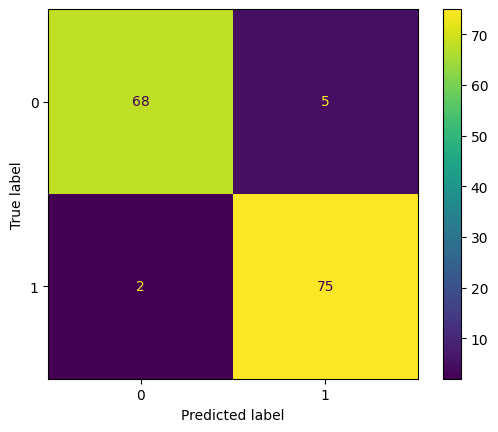

In [90]:
disp.plot()

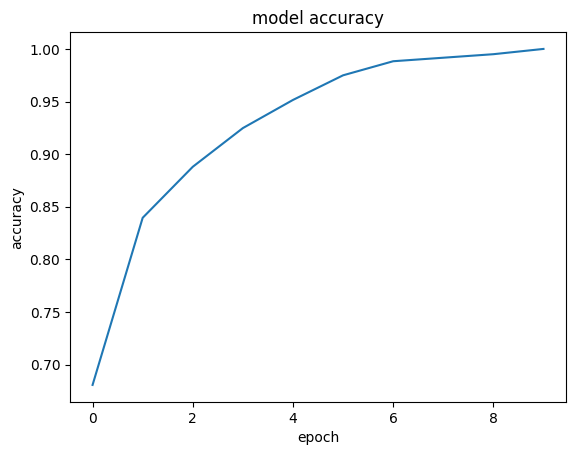

In [99]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


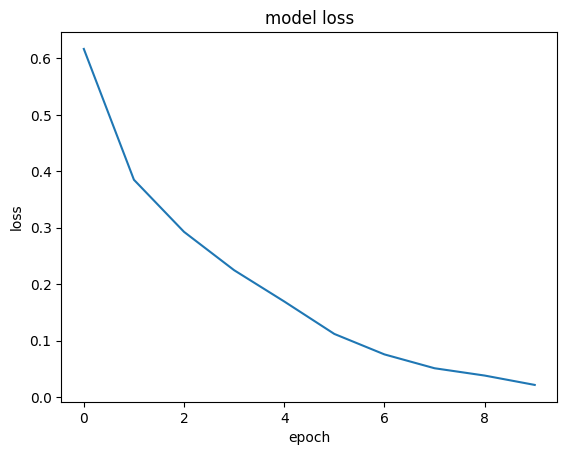

In [100]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Using CNN

In [105]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [107]:
model = Sequential()
model.add(layers.Conv1D(64,2,activation='relu',input_shape = x_train[0].shape))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(126,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [108]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 299, 64)           192       
                                                                 
 batch_normalization (BatchN  (None, 299, 64)          256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 299, 64)           0         
                                                                 
 flatten (Flatten)           (None, 19136)             0         
                                                                 
 dense_9 (Dense)             (None, 126)               2411262   
                                                                 
 dense_10 (Dense)            (None, 1)                 127       
                                                      

In [109]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics=['accuracy'])

In [110]:
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size = 64, epochs=10 )

Epoch 1/10
10/10 [==============================] - 3s 119ms/step - loss: 2.6823 - accuracy: 0.5635 - val_loss: 0.6219 - val_accuracy: 0.6133
Epoch 2/10
10/10 [==============================] - 1s 92ms/step - loss: 0.7852 - accuracy: 0.7174 - val_loss: 0.5558 - val_accuracy: 0.7867
Epoch 3/10
10/10 [==============================] - 1s 87ms/step - loss: 0.4455 - accuracy: 0.7876 - val_loss: 0.5876 - val_accuracy: 0.7400
Epoch 4/10
10/10 [==============================] - 1s 136ms/step - loss: 0.3309 - accuracy: 0.8629 - val_loss: 0.5742 - val_accuracy: 0.7533
Epoch 5/10
10/10 [==============================] - 2s 156ms/step - loss: 0.2785 - accuracy: 0.9013 - val_loss: 0.5958 - val_accuracy: 0.7467
Epoch 6/10
10/10 [==============================] - 1s 92ms/step - loss: 0.2471 - accuracy: 0.9197 - val_loss: 0.5492 - val_accuracy: 0.7867
Epoch 7/10
10/10 [==============================] - 1s 86ms/step - loss: 0.2129 - accuracy: 0.9298 - val_loss: 0.5328 - val_accuracy: 0.7867
Epoch 8/10

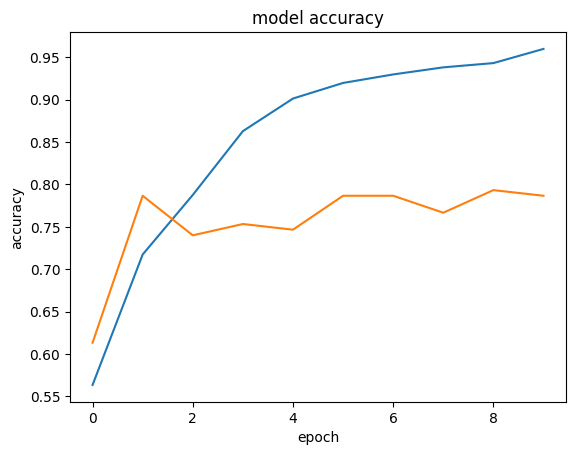

In [111]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()